### ==========================================================================================
# PART 5: DATA AUGMENTATION AND DEALING WITH CLASS IMBALANCE
### ==========================================================================================

In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from pandas_ml import ConfusionMatrix
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

Using TensorFlow backend.


In [2]:
# project folder
path_project = 'E:/DeepLearning/breast_cancer/IDC_regular_ps50_idx5/'

# set train, validate, and test folders
dir_train = os.path.join(path_project, '_train')
dir_valid = os.path.join(path_project, '_validate')
dir_test = os.path.join(path_project, '_test_single')

# dinamically read folders as categories, excluding files (i.e. contains ".") and train, validate and test folders when present
categories = [folder for folder in os.listdir(path_project) if not re.search(r'[\.|_|model]', folder, re.I)]

print('CATEGORIES:', categories)

CATEGORIES: ['0', '1']


### Training and performance functions

In [3]:
def train_model(model_x, model_id, lr, epochs, epoch_steps, valid_steps, batch_size, image_size, augment, correct_imbalance):
    model = model_x(lr=lr, image_size=image_size)
    
    print('Model:', model_x)
    print('Batch Size:', batch_size)
    print('Learning Rate:', lr)
    print('Epochs:', epochs)
    print('Steps per Epoch:', epoch_steps)
    print('Validation Steps:', valid_steps)
    print('Image Size:', image_size)
    print('_' * 65, '\n')
        
    print('Training Set:')   
    
    # data augmentation
    if augment:
        datagen_train = ImageDataGenerator(rescale=1./255, 
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           rotation_range=20,
                                           width_shift_range=0.02, 
                                           height_shift_range=0.02,
                                           brightness_range=[0.2,1.0])
    else:
        datagen_train = ImageDataGenerator(rescale=1./255)
    
    gen_train = datagen_train.flow_from_directory(dir_train, target_size=image_size, batch_size=batch_size, class_mode='binary')
    
    
    print('Validation Set:')    
    datagen_valid = ImageDataGenerator(rescale=1./255)
    gen_valid = datagen_valid.flow_from_directory(dir_valid, target_size=image_size, batch_size=batch_size, class_mode='binary')
    print('_' * 65, '\n')

    print('Model training started...\n')
    
    
    # calculate class weigths to account for class imbalance
    if correct_imbalance:
        files_cnt = []
        for category in categories:
            files = os.listdir(os.path.join(dir_train, category))
            files_cnt.append(int(len(files)))

        class_weights = {}
        for label in range(len(files_cnt)):
            class_weights.update({label : round(files_cnt[label]/sum(files_cnt)*100)})


        # start training
        t0 = datetime.now()
        with tf.device('/gpu:0'):
            history = model.fit_generator(gen_train, steps_per_epoch=epoch_steps, epochs=epochs, validation_data=gen_valid, 
                                                                        validation_steps=valid_steps, class_weight=class_weights)
    else:
        # start training
        t0 = datetime.now()
        with tf.device('/gpu:0'):
            history = model.fit_generator(gen_train, steps_per_epoch=epoch_steps, epochs=epochs, validation_data=gen_valid, 
                                                                        validation_steps=valid_steps)
            
    
    elpased_time = str(datetime.now() - t0).split('.')[0]    
    hours = elpased_time.split(':')[0]
    minutes = elpased_time.split(':')[1]
    seconds = elpased_time.split(':')[2]
    
    print('\nTraining process completed in:', int(hours), 'h', int(minutes), 'm', int(seconds), 's')            
    
    # save model
    models_folder = 'MODELS'    
    if not os.path.exists(os.path.join(path_project, models_folder)):
        os.makedirs(os.path.join(path_project, models_folder))
    filename = f"model_breast_cancer_{model_id}.h5"
    model.save(os.path.join(path_project, models_folder, filename))
    print('Model saved as: "', models_folder, '/', filename, '"')
    
    print('#' * 120, '\n')
    
    return (history, elpased_time, model)


def model_performance(model_name):
    model_test = load_model(os.path.join(path_project, 'MODELS', model_name))
    
    gen_test.reset()
    predictions = model_test.predict_generator(gen_test, verbose=1)
        
    # option 1: get img class from filenames in generator (both options match, but this is more reliable)
    y_true = [int(x.split('class')[1].split('.')[0]) for x in gen_test.filenames]  
    
    # option 2: get img class from filenames in folders
    #y_true = [int(file.split('_class')[1].split('.')[0]) for file in os.listdir(path_project + '_test_single' + '/test_folder')]
    
    # get predictions
    y_pred = [int(np.rint(pred[0])) for pred in predictions]
    
    # confusion matrix
    cm = ConfusionMatrix(y_true, y_pred)
    
    # model id
    model_id = re.sub('[^0-9]', '', model_name.split('.')[0])
    
    # performance metrics
    accuracy = cm.stats()['ACC']  # correct predictions
    precision = cm.stats()['PPV']  # positive predictive value
    sensitivity = cm.stats()['TPR']  # true positive rate, recall
    specificity = cm.stats()['TNR']  # true negative rate
    f1_score = cm.stats()['F1_score']  # weighted average of precision and recall (TPR)
    
    return [model_id, cm, accuracy, precision, sensitivity, specificity, f1_score]

### Function to plot model training results

In [4]:
def plot_training(acc, val_acc, loss, val_loss):
    epochs = range(1, len(acc) + 1)   
    plt.style.use('ggplot')    
    plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        
    plt.subplot(121, facecolor='whitesmoke')    
    plt.plot(epochs, acc, 'bo', label='Training acc', color='steelblue')
    plt.plot(epochs, val_acc, 'b', label='Validation acc', color='tomato')
    plt.title('Training and validation accuracy', size=16, weight='bold', color='#444444')
    plt.xticks(size=13)
    plt.yticks(size=13)
    plt.legend(loc='best', fontsize=14)
         
    plt.subplot(122, facecolor='whitesmoke')    
    plt.plot(epochs, loss, 'bo', label='Training loss', color='steelblue')
    plt.plot(epochs, val_loss, 'b', label='Validation loss', color='tomato')
    plt.title('Training and validation loss', size=16, weight='bold', color='#444444')
    plt.xticks(size=13)
    plt.yticks(size=13)    
    plt.legend(loc='best', fontsize=14)
        
    plt.subplots_adjust(wspace=0.3)    
    plt.show()

### Define model architecture

In [5]:
def model_7(lr, image_size):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['acc'])        
    model.summary()    
    return model

### Get best performing algorithm from previous training

In [6]:
# read generations file
df_generations = pd.read_csv(os.path.join(path_project, 'generations.csv')).fillna('')

# select only alive individuals
df_select = df_generations[df_generations.alive]

df_select = df_select.sort_values('val_acc', ascending=False).head(1).reset_index()
df_select

,index,batch_size,steps_per_epoch,validation_steps,epochs,learning_rate,train_loss,train_acc,val_loss,val_acc,time,gen,alive
0,653,100,190,10,90,0.0001,0.317655,0.865789,0.292571,0.894,0:11:41,1,True


### Train model with no imbalance correction or data augmentation (baseline model)

In [7]:
# comparison model name: 2000
logs_2000 = train_model(model_7, model_id=2000, lr=0.0001, epochs=90, epoch_steps=190, valid_steps=10, 
                                                batch_size=100, image_size=(50, 50), augment=False, correct_imbalance=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 128)         147584    
__________

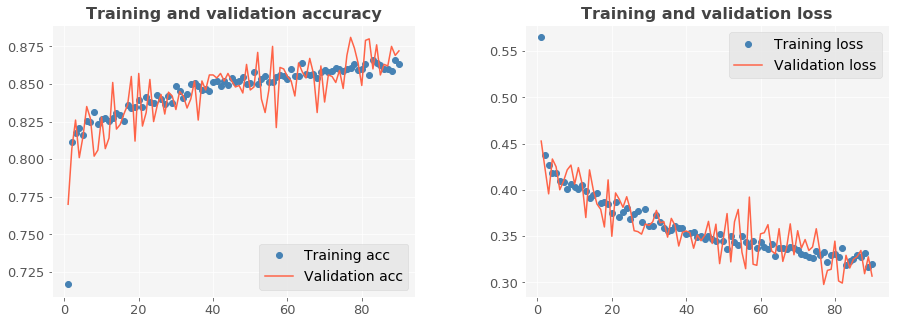

In [9]:
plot_training(logs_2000[0].history['acc'], logs_2000[0].history['val_acc'], 
                                                          logs_2000[0].history['loss'], logs_2000[0].history['val_loss'])

### Train model using correction for class imbalance only (no data augmentation)

In [10]:
# comparison model name: 2001
logs_2001 = train_model(model_7, model_id=2001, lr=0.0001, epochs=90, epoch_steps=190, valid_steps=10, 
                                                batch_size=100, image_size=(50, 50), augment=False, correct_imbalance=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 128)         147584    
__________

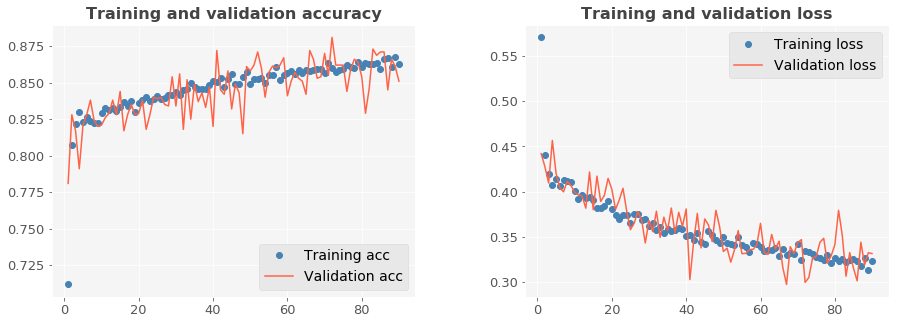

In [11]:
plot_training(logs_2001[0].history['acc'], logs_2001[0].history['val_acc'], 
                                                          logs_2001[0].history['loss'], logs_2001[0].history['val_loss'])

### Train model using correction for class imbalance and data augmentation

In [12]:
# comparison model name: 2002
logs_2002 = train_model(model_7, model_id=2002, lr=0.0001, epochs=90, epoch_steps=190, valid_steps=10, 
                                                batch_size=100, image_size=(50, 50), augment=False, correct_imbalance=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 128)         147584    
__________

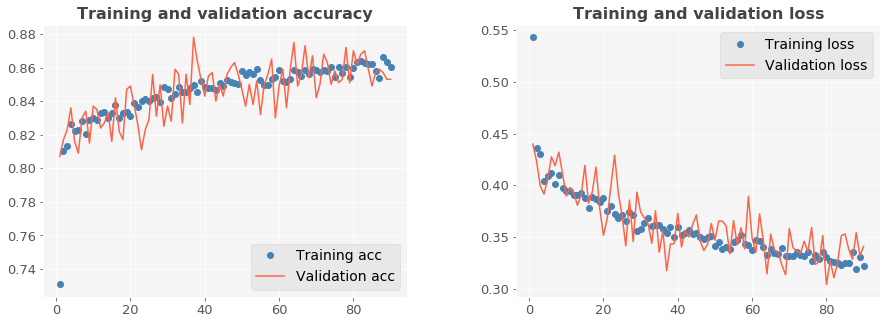

In [13]:
plot_training(logs_2002[0].history['acc'], logs_2002[0].history['val_acc'], 
                                                          logs_2002[0].history['loss'], logs_2002[0].history['val_loss'])

### Compare model performance metrics

In [14]:
# generator for imagesin test set
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_directory(dir_test, batch_size=1, target_size=(50,50), shuffle=False, class_mode=None)

Found 27752 images belonging to 1 classes.


In [15]:
m_2000 = model_performance('model_breast_cancer_2000.h5')
m_2001 = model_performance('model_breast_cancer_2001.h5')
m_2002 = model_performance('model_breast_cancer_2002.h5')

27752/27752 [==============================] - 36s 1ms/step


In [16]:
df_kpi = pd.DataFrame([m_2000, m_2001, m_2002])
df_kpi.columns = ['model_name', 'cm', 'accuracy', 'precision', 'sensitivity', 'specificity', 'f1_score']
df_kpi

,model_name,cm,accuracy,precision,sensitivity,specificity,f1_score
0,2000,Predicted False True __all__\nActual ...,0.864586,0.771870,0.742480,0.912998,0.756890
1,2001,Predicted False True __all__\nActual ...,0.865884,0.779556,0.735626,0.917526,0.756954
2,2002,Predicted False True __all__\nActual ...,0.863649,0.792041,0.704785,0.926634,0.745870
